# cluster a set of documents using Python

1. tokenizing
2. stemming (*based on stemming lib, results change)- reduce a word to its stem or root form
3. calculate cosine distance between each document = measure of similarity
4. cluster documents using the k-means algorithm
5. using multidimensional scaling to reduce dimensionality within the corpus
6. conduct a hierarchical clustering on the corpus using Ward clustering

References :
- https://datascienceschool.net/view-notebook/3e7aadbf88ed4f0d87a76f9ddc925d69/
- https://medium.com/@vegi/visualizing-higher-dimensional-data-using-t-sne-on-tensorboard-7dbf22682cf2

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import psycopg2
# import db_conn
from IPython.display import display
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

In [2]:
# conn = get_connection()

def get_article_tables(is_file):
    if is_file:
        return pd.read_csv('../data_cleansing/ddi_sent_wo_header.csv', sep=',', header=None)
#         return pd.read_csv('../data/titles_condition_by_t.tsv', sep='\t', header=None)
#         return pd.read_csv('../topic_modeling/best_files/dic_unigram_size_6000/mallet_top_sen.tsv', sep='\t')
    else:
        curs = conn.cursor()

        select_sql = """SELECT id, table_title, strip_tags(CONTENT) as content FROM article_tables order by id""" # limit 10000
        curs.execute(select_sql)
        return curs.fetchall()

In [7]:
train_data = get_article_tables(True)
# train_data = train_data[['id', 'Origin_Text']]
train_data.columns=['id', 'title']
# clean_content = [x['content'].lower() for x in train_data]

In [8]:
train_data.head()

,id,title
0,DDI-MedLine.d69.s0,Differential regulation of tyrosine phosphoryl...
1,DDI-MedLine.d69.s1,The homodimeric disintegrin contortrostatin wa...
2,DDI-MedLine.d69.s2,It was observed that contortrostatin had a dra...
3,DDI-MedLine.d69.s3,Echistatin alone had no effect on tyrosine pho...
4,DDI-MedLine.d69.s4,Among the proteins that undergo tyrosine phosp...


In [9]:
train_data.shape

(6905, 2)

In [10]:
train_data.loc[train_data.title.isna()]
train_data.loc[train_data.title.isnull()]

,id,title


,id,title


In [11]:
train_data.title = train_data.title.str.strip()
train_data['title'].replace('', np.nan, inplace=True)
print(train_data.isna().any())

id       False
title    False
dtype: bool


In [12]:
train_data.loc[train_data.title.isna()]
train_data.dropna(subset=['title'], inplace=True)
train_data = train_data.reset_index()
print(train_data.isna().any())

,id,title


index    False
id       False
title    False
dtype: bool


In [13]:
train_data.shape

(6905, 3)

In [14]:
train_data = train_data.astype(str)

In [16]:
# # rep = {'nbsp':'', 'table':'', 'legend':'', 'mg/dl':'', 'g/l':'', 'yrs':'year', '\n':' ', ';':'', 'kg/m2':'', 'n=':''}
# rep = {'nbsp':'', 'table':'', 'legend':'', 'yrs':'year', '\n':' '}
# # clean_content = [pattern.sub(lambda m: rep[re.escape(m.group(0))], x['content']) for x in train_data]
# rep = dict((re.escape(k), v) for k, v in rep.items())
# pattern = re.compile("|".join(rep.keys()))
# train_data.title = [pattern.sub(lambda m: rep[re.escape(m.group(0))], str(x)) for x in train_data.title]

KeyError: ''

In [17]:
train_data.title[:10]

0    Differential regulation of tyrosine phosphoryl...
1    The homodimeric disintegrin contortrostatin wa...
2    It was observed that contortrostatin had a dra...
3    Echistatin alone had no effect on tyrosine pho...
4    Among the proteins that undergo tyrosine phosp...
5    Flavoridin alone was found to have no effect o...
6    These observations strongly suggest that the h...
7    Toxicity of cadmium and zinc to encystment and...
8    The toxicity of cadmium, zinc and cadmium/zinc...
9    Cercarial encystment at concentrations of 2500...
Name: title, dtype: object

In [18]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import strip_numeric
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [19]:
np.random.seed(2018)

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/grace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
#stopwords
stemmer = SnowballStemmer('english')
STOP_WORDS = list(gensim.parsing.preprocessing.STOPWORDS)
STOP_WORDS.extend(['table', 'legend'])

In [21]:
# stemming
# -porter stemmer
# -lancaster stemmer
# -snowball stemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
#     deacc=True removes punctuations
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if token not in STOP_WORDS and len(token)>1:
#             result.append(lemmatize_stemming(strip_numeric(token)))
            result.append(lemmatize_stemming(token))
    return result

def preprocess_token_only(text):
    result = []
#     deacc=True removes punctuations
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if token not in STOP_WORDS and len(token)>1:
#             result.append(lemmatize_stemming(strip_numeric(token)))
            result.append(token)
    return result

stemmer = LancasterStemmer()
#tokenizing
def tokenize_and_stem(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    #filter tokens not containing letters
    filtered = []
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token)>2:
            filtered.append(token)
#     stems = [stemmer.stem(t, pos='v') for t in filtered]
    stems = [stemmer.stem(t) for t in filtered]
    return stems

def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered = []
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token)>2:
            filtered.append(token)
    return filtered

In [22]:
total_vocab_stemmed = []
total_vocab_tokenized = []

for i in train_data.title.tolist():
    all_stemmed = preprocess(i)
    total_vocab_stemmed.extend(all_stemmed)
    
    all_tokenized = preprocess_token_only(i)
    total_vocab_tokenized.extend(all_tokenized)

processed_docs = pd.DataFrame()
processed_docs = pd.concat([train_data.id, train_data.title.map(preprocess)], axis=1)

In [23]:
processed_docs[:10]

,id,title
0,DDI-MedLine.d69.s0,"[diff, reg, tyrosin, phosphoryl, tum, cel, con..."
1,DDI-MedLine.d69.s1,"[homodim, disintegrin, contortrostatin, comp, ..."
2,DDI-MedLine.d69.s2,"[observ, contortrostatin, dram, effect, tyrosi..."
3,DDI-MedLine.d69.s3,"[echistatin, effect, tyrosin, phosphoryl, cel,..."
4,DDI-MedLine.d69.s4,"[protein, undergo, tyrosin, phosphoryl, respon..."
5,DDI-MedLine.d69.s5,"[flavoridin, effect, cas, complet, block, cont..."
6,DDI-MedLine.d69.s6,"[observ, strongly, suggest, homodim, structure..."
7,DDI-MedLine.d141.s0,"[tox, cadm, zint, encyst, vitro, excyst, paror..."
8,DDI-MedLine.d141.s1,"[tox, cadm, zint, cadm, zint, mixt, cont, rang..."
9,DDI-MedLine.d141.s2,"[cerc, encyst, cont, microg, high, sign, impai..."


In [24]:
#create dataframe with stemmed vocab and tokenized words (link)
vocab_frame = pd.DataFrame({'words':total_vocab_tokenized}, index=total_vocab_stemmed)
vocab_frame.drop_duplicates(inplace=True)
vocab_frame.head()

,words
diff,differential
reg,regulation
tyrosin,tyrosine
phosphoryl,phosphorylation
tum,tumor


## Tf-idf and document similarity

In [ ]:
#frequency-inverse document frequencey(tf-idf) vectorize parameters and convert the document list into tf-idf matrix
# 1. count word occurrences by document
# 2. transform into a document-term matrix = term frequency matrix

#max_df = max frequency within the documents
#min_idf = if 5, the term would have to be in at least 5 of the documents to be considered, 0.2 = 20% of documents
#ngram_ranges

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                   max_features=10000, 
                                   min_df=0.01, 
                                   stop_words='english', 
                                   use_idf=True, 
                                   lowercase=True, 
                                   tokenizer=preprocess)
#                                    tokenizer=preprocess, ngram_range=(1,2))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(train_data.title)
print(tfidf_matrix.shape)

In [ ]:
terms = tfidf_vectorizer.get_feature_names()

In [ ]:
terms[:10]

Ref : http://www.pbarrett.net/techpapers/euclid.pdf
Normalize :

The problem of raw distance coefficient is that it has no obvious bound value for the maximum distance.
Basically you don't know from its size whether a coefficient indicates a small or large distance.

In [ ]:
%time tfidf_tsne_result = TSNE(learning_rate=300, init='pca', \
                               n_iter=250, random_state=0)\
                    .fit_transform(np.array(tfidf_matrix.toarray()))
tfidf_vect = normalize(tfidf_tsne_result, norm='l2')

### Visualization with Tensorboard

In [25]:
import os
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/Users/grace/workspace/keras/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/grace/workspace/keras/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
tf_data = tf.Variable(tfidf_tsne_result)
with tf.Session() as sess:
    saver = tf.train.Saver([tf_data])
    sess.run(tf_data.initializer)
#     saver.save(sess, os.path.join(LOG_DIR, 'tf_data.ckpt'))
    config = projector.ProjectorConfig()
    
    embedding = config.embeddings.add()
    embedding.tensor_name = tf_data.name
    
#     embedding.metadata_path = metadata
#     projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

In [ ]:
#dist = cosine similarity of each document
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(tfidf_matrix)

In [ ]:
dist

## HashingVectorizer, CountVectorizer

- 문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW 인코딩한 벡터를 만든다.
- HashingVectorizer를 사용하면 해시 함수를 사용하여 단어에 대한 인덱스 번호를 생성하기 때문에 메모리 및 실행 시간을 줄일 수 있다.

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

vect = CountVectorizer(max_df=0.9, \
                       min_df=0.01, \
                       max_features=10000,\
                       lowercase=True,\
                       tokenizer=preprocess,\
                       stop_words='english')
# vect = HashingVectorizer(n_features=10000,\
#                        lowercase=True,\
#                        tokenizer=preprocess,\
#                        stop_words='english')

# vect = CountVectorizer(max_df=0.8, min_df=0.02, ngram_range=(2,2))
count_matrix = vect.fit_transform(train_data.title)
vect.vocabulary_

{'absorb': 0,
 'acid': 1,
 'act': 2,
 'addit': 3,
 'adjust': 4,
 'admin': 5,
 'advers': 6,
 'affect': 7,
 'ag': 8,
 'alcohol': 9,
 'alt': 10,
 'ant': 11,
 'antacid': 12,
 'antagon': 13,
 'antibiot': 14,
 'anticoag': 15,
 'antidepress': 16,
 'approxim': 17,
 'aspirin': 18,
 'assocy': 19,
 'auc': 20,
 'avoid': 21,
 'bas': 22,
 'bet': 23,
 'bind': 24,
 'block': 25,
 'blood': 26,
 'calc': 27,
 'car': 28,
 'carbamazepin': 29,
 'cardiac': 30,
 'cas': 31,
 'caus': 32,
 'caut': 33,
 'cel': 34,
 'certain': 35,
 'chang': 36,
 'cimetidin': 37,
 'clear': 38,
 'clin': 39,
 'clos': 40,
 'cmax': 41,
 'cns': 42,
 'coadmin': 43,
 'combin': 44,
 'comp': 45,
 'concomit': 46,
 'concur': 47,
 'conduc': 48,
 'consid': 49,
 'cont': 50,
 'contain': 51,
 'contraceiv': 52,
 'control': 53,
 'corticosteroid': 54,
 'cyclosporin': 55,
 'cyp': 56,
 'cytochrom': 57,
 'dai': 58,
 'dat': 59,
 'day': 60,
 'decreas': 61,
 'demonst': 62,
 'depend': 63,
 'depress': 64,
 'determin': 65,
 'diff': 66,
 'digoxin': 67,
 'discon

In [53]:
len(vect.vocabulary_)

187

In [27]:
%time count_tsne_result = TSNE(learning_rate=300, init='pca')\
                    .fit_transform(np.array(count_matrix.toarray()))
count_vect = normalize(count_tsne_result, norm='l2')

CPU times: user 3min 15s, sys: 12.5 s, total: 3min 28s
Wall time: 3min 40s


In [54]:
terms = vect.get_feature_names()

In [61]:
#k-means- predetermined number of clusters
nums =[8]
from sklearn.cluster import KMeans
from __future__ import print_function

def run_kmeans(vect):
#     for num in nums:
#         print('cluster : %s' % str(num))
    num_clusters = 3
    km = KMeans(n_clusters=num_clusters,\
                random_state=0,\
                init='random',\
                algorithm='auto',\
                max_iter=30000)
    %time km.fit_predict(vect)
    clusters = km.labels_.tolist()

    documents = {'id':[x for x in processed_docs.id],
                'content': train_data.title.tolist(),
                 'title': processed_docs.title.tolist(),
                'cluster':clusters}

    clu_docu = pd.DataFrame(documents, index=[clusters], columns=['id','content','title','cluster'])

    print(clu_docu['cluster'].value_counts())

    #top words nearest to the cluster centroid
    print('Top terms per clusters')
    print()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    for i in range(num_clusters):
        print('Cluster %d words:' % i, end='')

        for ind in order_centroids[i, :]:
            print('%s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
        print()

        print("Cluster %d titles:" % i, end='')
        adver_contents = [x for x in clu_docu.loc[i]['content'].tolist() if x.lower().find('advers')>=0]
#         print('count of adverse included in content %s' % str(len(adver_contents)))

    return km, clu_docu, km.cluster_centers_, clusters

In [ ]:
km, tfidf_clu, tfidf_centers = run_kmeans(tfidf_vect)

In [62]:
km, tfidf_clu, tfidf_centers, clusters= run_kmeans(count_vect)
import pickle

output = open('../data/output/kmeans.pkl', 'wb')
pickle.dump({'topic_model': km}, output)
output.close()

CPU times: user 71.6 ms, sys: 1.83 ms, total: 73.5 ms
Wall time: 72.3 ms
2    2528
1    2250
0    2127
Name: cluster, dtype: int64
Top terms per clusters

Cluster 0 words:absorption,acid,
Cluster 0 titles:count of adverse included in content 27
Cluster 1 words:absorption,acid,
Cluster 1 titles:count of adverse included in content 33
Cluster 2 words:acid,absorption,
Cluster 2 titles:count of adverse included in content 53


In [71]:
from sklearn.metrics.cluster import silhouette_score, silhouette_samples
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import mglearn
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [68]:
# x, y = make_moons(n_samples=6905, noise=0.05, random_state=0)
# scaler = StandardScaler()
# scaler.fit(x)

# x_scaled = scaler.transform(x)
# random_state = np.random.RandomState(seed=0)
# random_clusters = random_state.randint(low=0, high=2, size=len(x))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [69]:
# print('{} : {:.2f}'.format(km.__class__.__name__, silhouette_score(x_scaled, clusters)))

KMeans : -0.01


(-0.1, 1)

(0, 6935)

For n_clusters = 2 The average silhouette_score is : 0.45184192


Text(-0.05, 1779.5, '0')

Text(-0.05, 5242.0, '1')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 2')

(-0.1, 1)

(0, 6945)

For n_clusters = 3 The average silhouette_score is : 0.49557245


Text(-0.05, 1079.0, '0')

Text(-0.05, 3276.5, '1')

Text(-0.05, 5670.0, '2')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 3')

(-0.1, 1)

(0, 6955)

For n_clusters = 4 The average silhouette_score is : 0.52146983


Text(-0.05, 842.0, '0')

Text(-0.05, 2632.5, '1')

Text(-0.05, 4489.0, '2')

Text(-0.05, 6171.0, '3')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 4')

(-0.1, 1)

(0, 6965)

For n_clusters = 5 The average silhouette_score is : 0.5524524


Text(-0.05, 722.5, '0')

Text(-0.05, 2154.0, '1')

Text(-0.05, 3454.0, '2')

Text(-0.05, 4773.5, '3')

Text(-0.05, 6233.5, '4')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 5')

(-0.1, 1)

(0, 6975)

For n_clusters = 6 The average silhouette_score is : 0.5610937


Text(-0.05, 684.5, '0')

Text(-0.05, 2048.0, '1')

Text(-0.05, 3138.0, '2')

Text(-0.05, 4183.5, '3')

Text(-0.05, 5360.0, '4')

Text(-0.05, 6433.5, '5')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 6')

(-0.1, 1)

(0, 6985)

For n_clusters = 7 The average silhouette_score is : 0.5595883


Text(-0.05, 623.5, '0')

Text(-0.05, 1789.5, '1')

Text(-0.05, 2710.0, '2')

Text(-0.05, 3532.0, '3')

Text(-0.05, 4505.0, '4')

Text(-0.05, 5422.0, '5')

Text(-0.05, 6397.5, '6')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 7')

(-0.1, 1)

(0, 6995)

For n_clusters = 8 The average silhouette_score is : 0.55387527


Text(-0.05, 348.0, '0')

Text(-0.05, 1190.0, '1')

Text(-0.05, 2095.0, '2')

Text(-0.05, 2880.5, '3')

Text(-0.05, 3767.0, '4')

Text(-0.05, 4625.0, '5')

Text(-0.05, 5575.5, '6')

Text(-0.05, 6582.5, '7')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 8')

(-0.1, 1)

(0, 7005)

For n_clusters = 9 The average silhouette_score is : 0.5535027


Text(-0.05, 287.5, '0')

Text(-0.05, 1000.0, '1')

Text(-0.05, 1807.5, '2')

Text(-0.05, 2680.5, '3')

Text(-0.05, 3528.0, '4')

Text(-0.05, 4258.0, '5')

Text(-0.05, 4941.5, '6')

Text(-0.05, 5586.5, '7')

Text(-0.05, 6463.0, '8')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'The visualization of the clustered data.')

Text(0.5, 0, 'Feature space for the 1st feature')

Text(0, 0.5, 'Feature space for the 2nd feature')

Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 9')

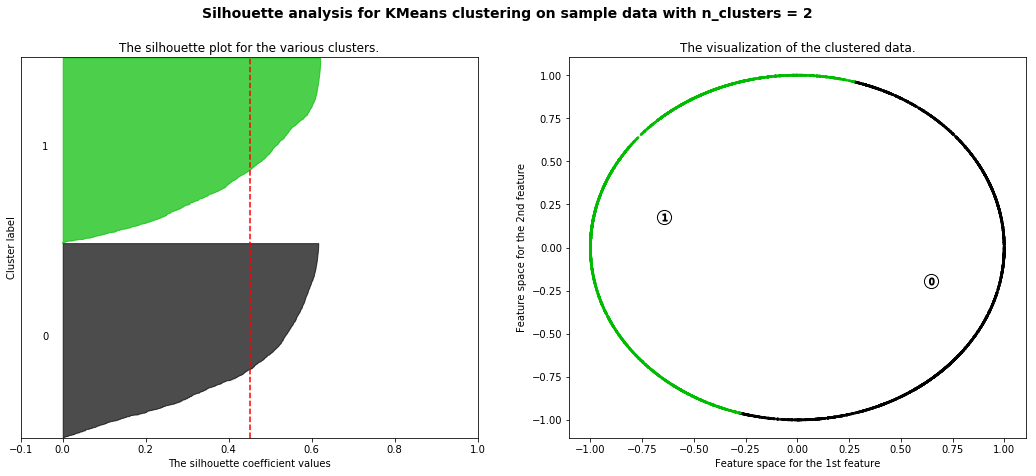

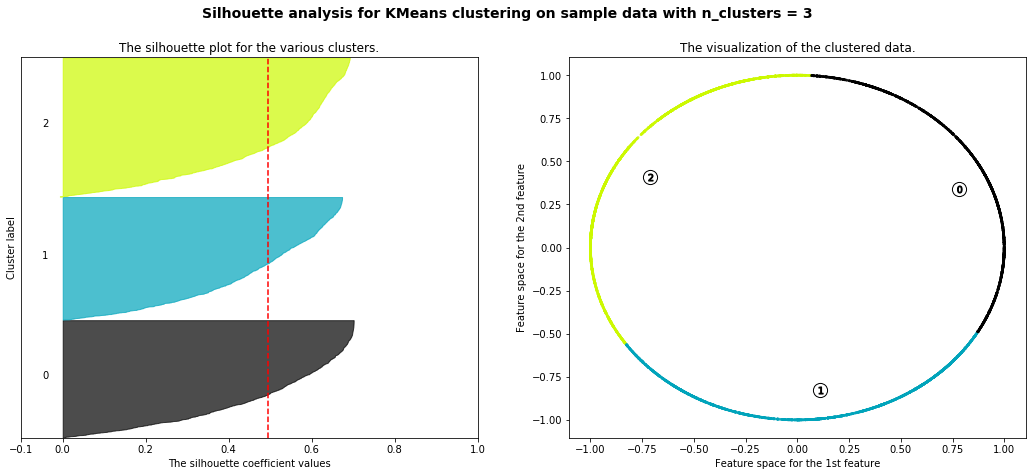

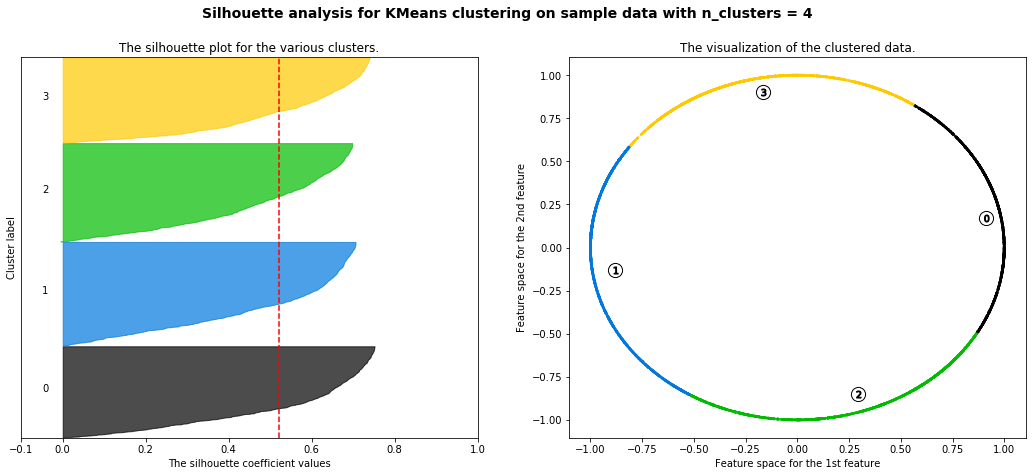

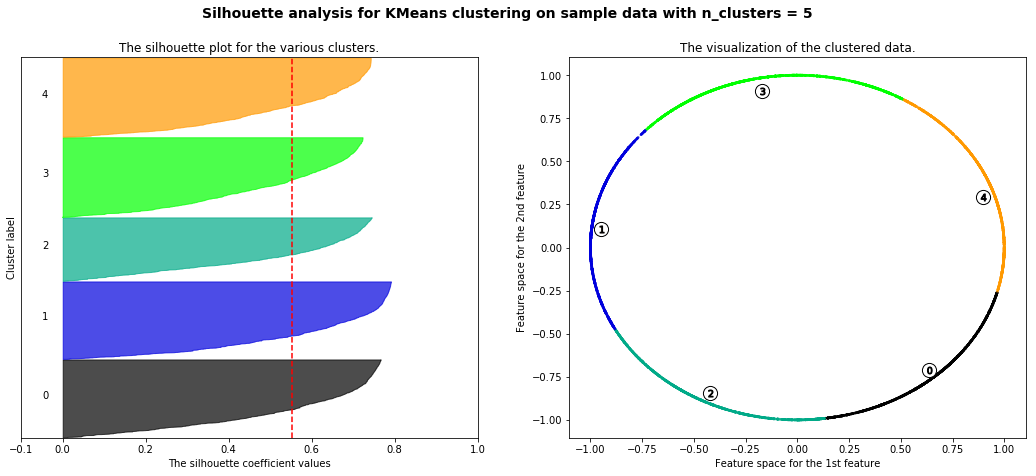

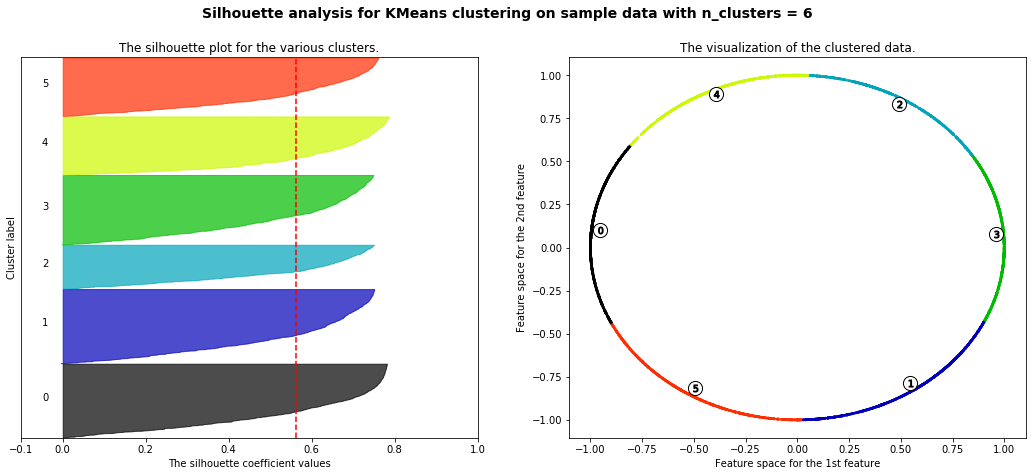

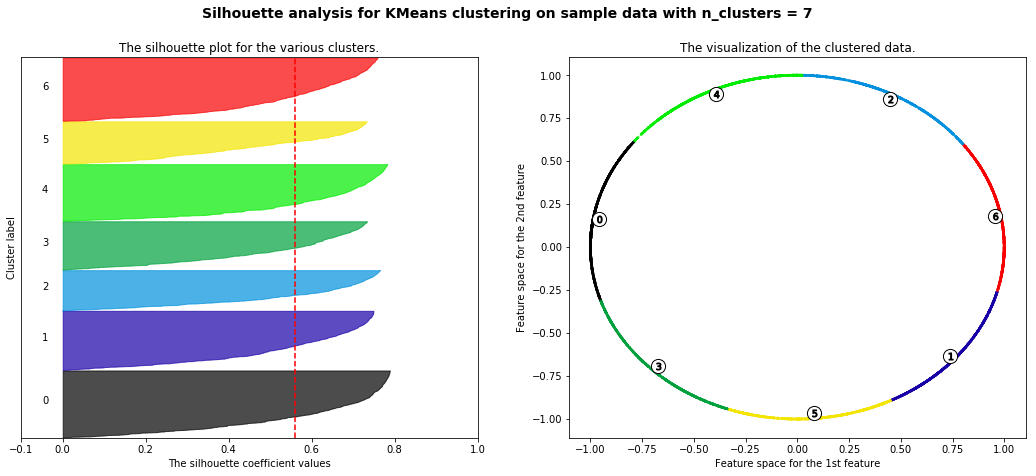

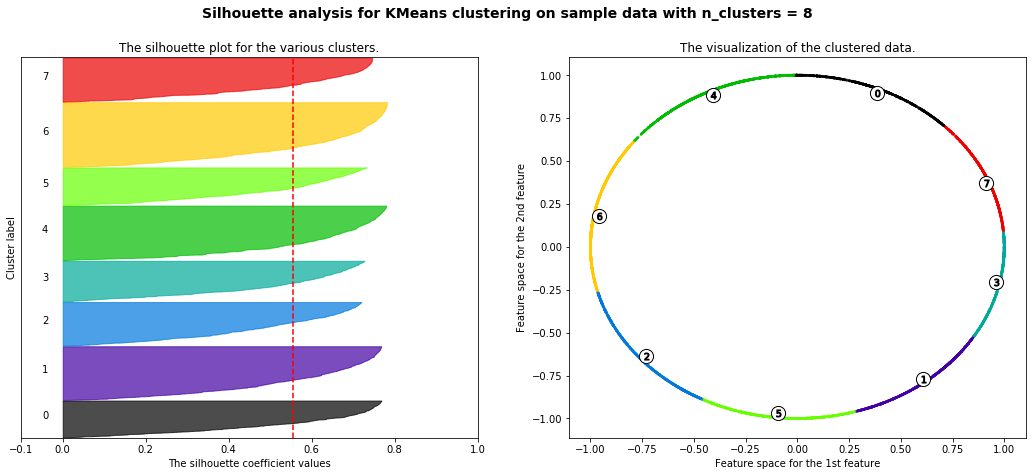

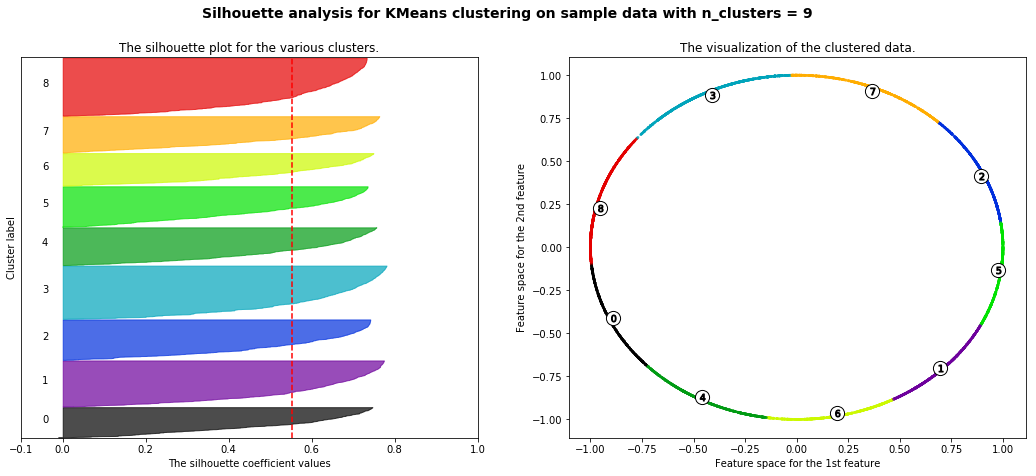

In [82]:
from sklearn.datasets import make_blobs
import matplotlib.cm as cm

# X, y = make_blobs(n_samples=500,
#                   n_features=2,
#                   centers=4,
#                   cluster_std=1,
#                   center_box=(-10.0, 10.0),
#                   shuffle=True,
#                   random_state=1)  # For reproducibility
X = count_vect

range_n_clusters = [i for i in range(2, 10)]
# print(range_n_clusters)

avg_scores = {}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    avg_scores[n_clusters]=silhouette_avg

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [83]:
avg_scores

{2: 0.45184192,
 3: 0.49557245,
 4: 0.52146983,
 5: 0.5524524,
 6: 0.5610937,
 7: 0.5595883,
 8: 0.55387527,
 9: 0.5535027}